In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
batch_size = 32
num_workers = 1

# for new_processed
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder('new_processed/train', transform=transform)
val_data = torchvision.datasets.ImageFolder('new_processed/validation', transform=transform)
test_data = torchvision.datasets.ImageFolder('new_processed/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(len(train_loader), len(val_loader), len(test_loader))

612 142 138


In [3]:
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)

training: torch.Size([32, 3, 128, 128]) torch.Size([32])


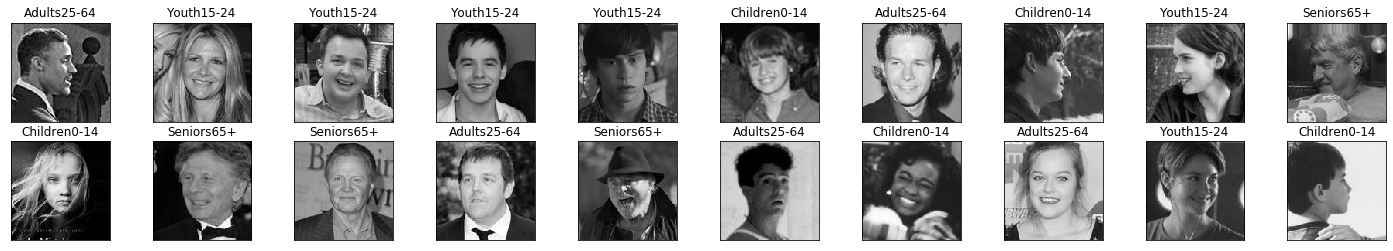

In [4]:
classes = ['Adults25-64', 'Children0-14', 'Seniors65+', 'Youth15-24']
# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Our Model

In [14]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = "AgeNet"
        # input layer is 3*128*128
        self.conv1 = nn.Conv2d(3, 5, 5, stride = 1, padding = 2) # output layer is 5*64*64
        self.pool1 = nn.MaxPool2d(4, 4) # output layer is 5*32*32
        self.conv2 = nn.Conv2d(5, 10, 5, stride = 1, padding = 2) # output layer is 10*32*32
        self.pool2 = nn.MaxPool2d(2, 2)  # output layer is 10*16*16
        self.conv3 = nn.Conv2d(10, 20, 5, stride = 1, padding = 2) # output layer is 20*16*16
        self.fc1 = nn.Linear(20*16*16, 32) # outputing 32
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
#         x = F.softmax(x, dim=1)
        return x

### Training Code

In [7]:
# function that calculates the accuracy
def get_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# function to train the model
def train(model, train_data, batch_size=32, lr=0.01, num_epochs=1, is_overfit=False):
#     torch.manual_seed(2) # set the random seed
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    if is_overfit:
        overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss() # use cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr) # use adam optimizer

    iters, train_acc, train_loss, val_acc = [], [], [], []

    # training
    print("training now...")
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            output = model(imgs)             # forward pass
            prob = F.softmax(output, dim=1)
            loss = criterion(prob, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)    # compute *average* loss
        
        if is_overfit:
            training_accuracy = get_accuracy(model, overfit_loader, batch_size)
            train_acc.append(training_accuracy)
            validation_accuracy = get_accuracy(model, overfit_loader, batch_size)
            val_acc.append(validation_accuracy)
        else:
            training_accuracy = get_accuracy(model, train_loader, batch_size)
            train_acc.append(training_accuracy) # compute training accuracy
            validation_accuracy = get_accuracy(model, val_loader, batch_size)
            val_acc.append(validation_accuracy)

        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, training_accuracy, validation_accuracy))
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [8]:
use_cuda = torch.cuda.is_available()

### Overfit to small dataset

training now...
Epoch 0 - Training Accuracy: 0.25, Validation Accuracy: 0.25
Epoch 1 - Training Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch 2 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 3 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 4 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 5 - Training Accuracy: 0.3125, Validation Accuracy: 0.3125
Epoch 6 - Training Accuracy: 0.34375, Validation Accuracy: 0.34375
Epoch 7 - Training Accuracy: 0.40625, Validation Accuracy: 0.40625
Epoch 8 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 9 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 10 - Training Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch 11 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 12 - Training Accuracy: 0.65625, Validation Accuracy: 0.65625
Epoch 13 - Training Accuracy: 0.65625, Validation Accuracy: 0.65625
Epoch 14 - Training Accuracy: 0.65625, Validation Accu

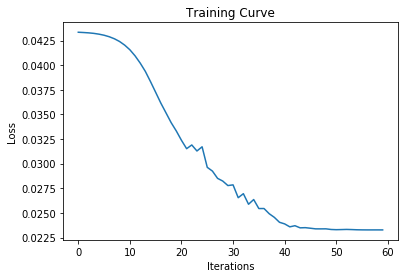

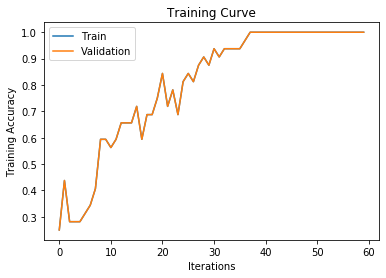

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [15]:
overfit_data = torchvision.datasets.ImageFolder('new_processed/overfit', transform=transform)
overfit_model = AgeNet()
if use_cuda:
    overfit_model = overfit_model.cuda()
train(overfit_model, overfit_data, batch_size=32, lr=0.001, num_epochs=60, is_overfit=True)

### Train the model

tensor([1.5057e-05, 1.7240e-02, 2.3619e-21, 9.8275e-01],
       grad_fn=<SelectBackward>)
tensor(3)


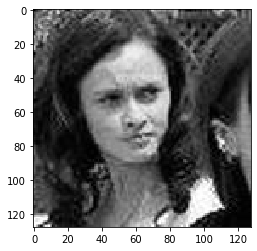

In [68]:
myiter = iter(test_loader)
imgs, labels = myiter.next()
imgs = torch.from_numpy(imgs.detach().numpy())
# plt.imshow(imgs[0].view(-1,128))
plt.imshow(np.transpose(imgs[0].numpy(), (1, 2, 0)))

# imgs = imgs.cuda()
model = AgeNet()
model.load_state_dict(torch.load('models/model3.pth'))
model.eval()
output = model(imgs)
prob = F.softmax(output, dim=1)
# print('output: ', prob.max(1, keepdim=True)[1])
# print('probability: ', prob.max(1, keepdim=True)[0])
# ['Adults25-64', 'Children0-14', 'Seniors65+', 'Youth15-24']
print(prob[0])
print(labels[0])

#####################################################################################

training now...
Epoch 0 - Training Accuracy: 0.3595744680851064, Validation Accuracy: 0.3502673796791444
Epoch 1 - Training Accuracy: 0.39373977086743045, Validation Accuracy: 0.3747135217723453
Epoch 2 - Training Accuracy: 0.4126432078559738, Validation Accuracy: 0.3783422459893048
Epoch 3 - Training Accuracy: 0.4359656301145663, Validation Accuracy: 0.39438502673796794
Epoch 4 - Training Accuracy: 0.4513911620294599, Validation Accuracy: 0.38636363636363635
Epoch 5 - Training Accuracy: 0.44173486088379704, Validation Accuracy: 0.3806340718105424
Epoch 6 - Training Accuracy: 0.49210310965630116, Validation Accuracy: 0.40240641711229946
Epoch 7 - Training Accuracy: 0.513911620294599, Validation Accuracy: 0.39763177998472116
Epoch 8 - Training Accuracy: 0.5336743044189852, Validation Accuracy: 0.4069900687547746
Epoch 9 - Training Accuracy: 0.5437397708674304, Validation Accuracy: 0.39763177998472116
Epoch 10 - Training Accuracy: 0.5703355155482815, Validation Accuracy: 0.40297937356760

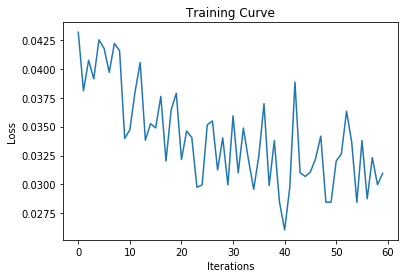

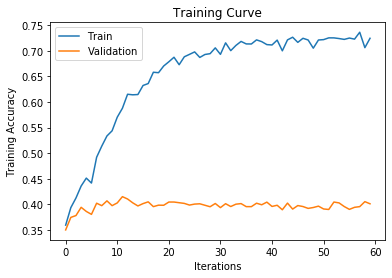

Final Training Accuracy: 0.7243862520458265
Final Validation Accuracy: 0.4012605042016807


In [14]:
model = AgeNet()
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=60)

training now...
Epoch 0 - Training Accuracy: 0.3736088379705401, Validation Accuracy: 0.36019862490450727
Epoch 1 - Training Accuracy: 0.3932487725040916, Validation Accuracy: 0.38330786860198623
Epoch 2 - Training Accuracy: 0.4123567921440262, Validation Accuracy: 0.3865546218487395
Epoch 3 - Training Accuracy: 0.42340425531914894, Validation Accuracy: 0.39686783804430864
Epoch 4 - Training Accuracy: 0.44046644844517185, Validation Accuracy: 0.3997326203208556
Epoch 5 - Training Accuracy: 0.4555646481178396, Validation Accuracy: 0.4045072574484339
Epoch 6 - Training Accuracy: 0.45785597381342064, Validation Accuracy: 0.4027883880825057
Epoch 7 - Training Accuracy: 0.47442716857610473, Validation Accuracy: 0.4045072574484339
Epoch 8 - Training Accuracy: 0.49631751227495907, Validation Accuracy: 0.40813598166539344
Epoch 9 - Training Accuracy: 0.5034779050736498, Validation Accuracy: 0.41462948815889994
Epoch 10 - Training Accuracy: 0.519189852700491, Validation Accuracy: 0.410236822001

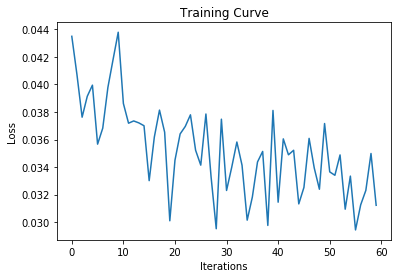

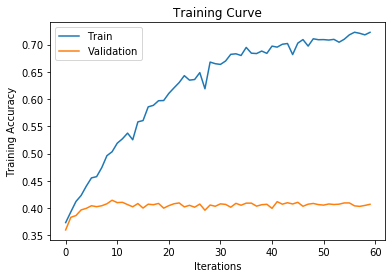

Final Training Accuracy: 0.7224222585924713
Final Validation Accuracy: 0.40718105423987777


In [9]:
model2 = AgeNet()
if use_cuda:
    model2 = model2.cuda()
train(model2, train_data, batch_size=32, lr=0.0005, num_epochs=60)

In [10]:
model3 = AgeNet()
if use_cuda:
    model3 = model3.cuda()
train(model3, train_data, batch_size=32, lr=0.0001, num_epochs=60)

training now...
Epoch 0 - Training Accuracy: 0.32962356792144026, Validation Accuracy: 0.3235294117647059
Epoch 1 - Training Accuracy: 0.3546644844517185, Validation Accuracy: 0.34358288770053474
Epoch 2 - Training Accuracy: 0.3747545008183306, Validation Accuracy: 0.36210847975553856Epoch 3 - Training Accuracy: 0.3861702127659574, Validation Accuracy: 0.3716577540106952
Epoch 4 - Training Accuracy: 0.39717675941080194, Validation Accuracy: 0.3739495798319328
Epoch 5 - Training Accuracy: 0.4045008183306056, Validation Accuracy: 0.3850267379679144
Epoch 6 - Training Accuracy: 0.41202945990180034, Validation Accuracy: 0.3894194041252865
Epoch 7 - Training Accuracy: 0.41620294599018004, Validation Accuracy: 0.39285714285714285
Epoch 8 - Training Accuracy: 0.41812602291325696, Validation Accuracy: 0.3917112299465241
Epoch 9 - Training Accuracy: 0.41526186579378066, Validation Accuracy: 0.3962948815889992
Epoch 10 - Training Accuracy: 0.42319967266775776, Validation Accuracy: 0.387318563789

KeyboardInterrupt: 

In [12]:
# changed Adam weight decay = 5e-4
model4 = AgeNet()
if use_cuda:
    model4 = model4.cuda()
train(model4, train_data, batch_size=32, lr=0.001, num_epochs=60)

training now...
Epoch 0 - Training Accuracy: 0.367430441898527, Validation Accuracy: 0.3567608861726509
Epoch 1 - Training Accuracy: 0.3762684124386252, Validation Accuracy: 0.3552330022918258
Epoch 2 - Training Accuracy: 0.3740998363338789, Validation Accuracy: 0.3665011459129106
Epoch 3 - Training Accuracy: 0.42013093289689035, Validation Accuracy: 0.38884644766997706
Epoch 4 - Training Accuracy: 0.418657937806874, Validation Accuracy: 0.38712757830404887
Epoch 5 - Training Accuracy: 0.4286415711947627, Validation Accuracy: 0.3865546218487395
Epoch 6 - Training Accuracy: 0.44742225859247137, Validation Accuracy: 0.39992360580595876
Epoch 7 - Training Accuracy: 0.44930441898527007, Validation Accuracy: 0.40756302521008403
Epoch 8 - Training Accuracy: 0.45159574468085106, Validation Accuracy: 0.39572192513368987
Epoch 9 - Training Accuracy: 0.45687397708674304, Validation Accuracy: 0.4039343009931245
Epoch 10 - Training Accuracy: 0.4805646481178396, Validation Accuracy: 0.4092818945760

KeyboardInterrupt: 

In [14]:
# changed Adam weight decay = 5e-5
model5 = AgeNet()
if use_cuda:
    model5 = model5.cuda()
train(model5, train_data, batch_size=32, lr=0.001, num_epochs=60)

training now...
Epoch 0 - Training Accuracy: 0.3564238952536825, Validation Accuracy: 0.34759358288770054
Epoch 1 - Training Accuracy: 0.39566284779050737, Validation Accuracy: 0.37662337662337664
Epoch 2 - Training Accuracy: 0.4095335515548281, Validation Accuracy: 0.3852177234530176
Epoch 3 - Training Accuracy: 0.4155891980360065, Validation Accuracy: 0.3792971734148205
Epoch 4 - Training Accuracy: 0.44930441898527007, Validation Accuracy: 0.3955309396485867
Epoch 5 - Training Accuracy: 0.45887888707037644, Validation Accuracy: 0.39343009931245226
Epoch 6 - Training Accuracy: 0.487847790507365, Validation Accuracy: 0.41233766233766234
Epoch 7 - Training Accuracy: 0.49451718494271685, Validation Accuracy: 0.4014514896867838
Epoch 8 - Training Accuracy: 0.5311374795417348, Validation Accuracy: 0.4125286478227655
Epoch 9 - Training Accuracy: 0.5525368248772504, Validation Accuracy: 0.4092818945760122
Epoch 10 - Training Accuracy: 0.5574468085106383, Validation Accuracy: 0.40851795263559

KeyboardInterrupt: 

In [15]:
# Adam weight decay = 5e-5
model5 = AgeNet()
if use_cuda:
    model5 = model5.cuda()
train(model5, train_data, batch_size=32, lr=0.0005, num_epochs=60)

training now...
Epoch 0 - Training Accuracy: 0.25, Validation Accuracy: 0.25
Epoch 1 - Training Accuracy: 0.25, Validation Accuracy: 0.25
Epoch 2 - Training Accuracy: 0.25, Validation Accuracy: 0.25
Epoch 3 - Training Accuracy: 0.2516366612111293, Validation Accuracy: 0.25286478227654696
Epoch 4 - Training Accuracy: 0.3395662847790507, Validation Accuracy: 0.3355614973262032
Epoch 5 - Training Accuracy: 0.35720130932896893, Validation Accuracy: 0.3430099312452254
Epoch 6 - Training Accuracy: 0.37054009819967265, Validation Accuracy: 0.35141329258976317
Epoch 7 - Training Accuracy: 0.388379705400982, Validation Accuracy: 0.36038961038961037
Epoch 8 - Training Accuracy: 0.405810147299509, Validation Accuracy: 0.3783422459893048
Epoch 9 - Training Accuracy: 0.42025368248772504, Validation Accuracy: 0.38330786860198623
Epoch 10 - Training Accuracy: 0.42950081833060555, Validation Accuracy: 0.390183346065699
Epoch 11 - Training Accuracy: 0.4454582651391162, Validation Accuracy: 0.3907563025

KeyboardInterrupt: 

training now...
Epoch 0 - Training Accuracy: 0.3598199672667758, Validation Accuracy: 0.35561497326203206
Epoch 1 - Training Accuracy: 0.3843698854337152, Validation Accuracy: 0.36764705882352944
Epoch 2 - Training Accuracy: 0.4027823240589198, Validation Accuracy: 0.3762414056531704
Epoch 3 - Training Accuracy: 0.408633387888707, Validation Accuracy: 0.3762414056531704
Epoch 4 - Training Accuracy: 0.42749590834697215, Validation Accuracy: 0.3989686783804431
Epoch 5 - Training Accuracy: 0.4307283142389525, Validation Accuracy: 0.387318563789152
Epoch 6 - Training Accuracy: 0.45875613747954175, Validation Accuracy: 0.3961038961038961
Epoch 7 - Training Accuracy: 0.46055646481178397, Validation Accuracy: 0.40106951871657753
Epoch 8 - Training Accuracy: 0.4785597381342062, Validation Accuracy: 0.39877769289533993
Epoch 9 - Training Accuracy: 0.48735679214402616, Validation Accuracy: 0.400305576776165
Epoch 10 - Training Accuracy: 0.4920621931260229, Validation Accuracy: 0.403170359052712


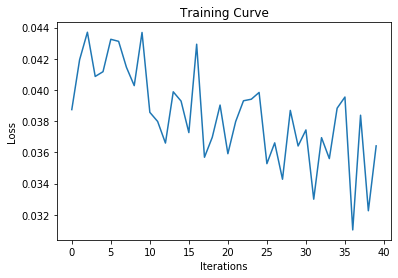

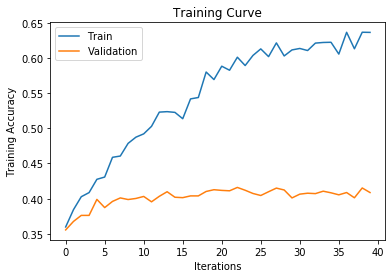

Final Training Accuracy: 0.6362111292962357
Final Validation Accuracy: 0.4087089381207028


In [16]:
model = AgeNet()
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=40)

training now...
Epoch 0 - Training Accuracy: 0.36646279306829765, Validation Accuracy: 0.33898678414096917
Epoch 1 - Training Accuracy: 0.3944104655113829, Validation Accuracy: 0.3931718061674009
Epoch 2 - Training Accuracy: 0.4128865103635746, Validation Accuracy: 0.3973568281938326
Epoch 3 - Training Accuracy: 0.4250339789330615, Validation Accuracy: 0.3958149779735683
Epoch 4 - Training Accuracy: 0.44860686374447845, Validation Accuracy: 0.4024229074889868
Epoch 5 - Training Accuracy: 0.47608732585796804, Validation Accuracy: 0.41894273127753306Epoch 6 - Training Accuracy: 0.49749405368671423, Validation Accuracy: 0.4171806167400881
Epoch 7 - Training Accuracy: 0.48887189942235815, Validation Accuracy: 0.404625550660793Epoch 8 - Training Accuracy: 0.5364848793747876, Validation Accuracy: 0.41409691629955947
Epoch 9 - Training Accuracy: 0.5485898742779477, Validation Accuracy: 0.4182819383259912
Epoch 10 - Training Accuracy: 0.5614169215086646, Validation Accuracy: 0.4125550660792951

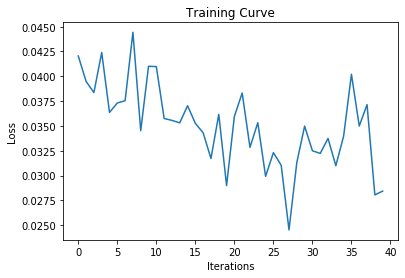

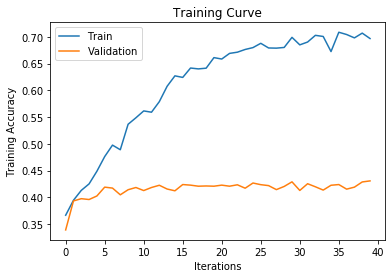

Final Training Accuracy: 0.6967380224260958
Final Validation Accuracy: 0.43061674008810574


PermissionError: [Errno 13] Permission denied: 'models'

In [9]:
model = AgeNet()
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=40)
torch.save(model.state_dict(), 'models') # thought I should put a path here but should be filename

training now...
Epoch 0 - Training Accuracy: 0.7057849133537207, Validation Accuracy: 0.4259911894273128
Epoch 1 - Training Accuracy: 0.6874362895005097, Validation Accuracy: 0.4156387665198238
Epoch 2 - Training Accuracy: 0.7131328576282705, Validation Accuracy: 0.4233480176211454
Epoch 3 - Training Accuracy: 0.716063540604825, Validation Accuracy: 0.42400881057268724
Epoch 4 - Training Accuracy: 0.7134726469588855, Validation Accuracy: 0.4185022026431718
Epoch 6 - Training Accuracy: 0.7090978593272171, Validation Accuracy: 0.4204845814977974
Epoch 7 - Training Accuracy: 0.7112640163098879, Validation Accuracy: 0.4275330396475771
Epoch 8 - Training Accuracy: 0.7176350662589195, Validation Accuracy: 0.4277533039647577Epoch 9 - Training Accuracy: 0.7144920149507306, Validation Accuracy: 0.41806167400881056
Epoch 10 - Training Accuracy: 0.719164118246687, Validation Accuracy: 0.42422907488986783Epoch 11 - Training Accuracy: 0.7274464831804281, Validation Accuracy: 0.42400881057268724
Epo

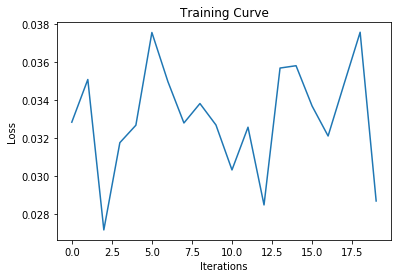

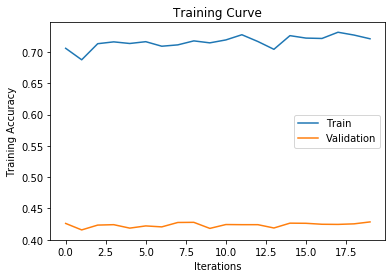

Final Training Accuracy: 0.7209904858987428
Final Validation Accuracy: 0.42841409691629956


In [11]:
#continue
train(model, train_data, batch_size=32, lr=0.001, num_epochs=20)
torch.save(model.state_dict(), 'models/model.pth') # now I know that I should save it as a .pth file

training now...
Epoch 0 - Training Accuracy: 0.25276078831124704, Validation Accuracy: 0.2801762114537445
Epoch 1 - Training Accuracy: 0.35278627251104316, Validation Accuracy: 0.3354625550660793
Epoch 2 - Training Accuracy: 0.3851087325857968, Validation Accuracy: 0.3491189427312775
Epoch 3 - Training Accuracy: 0.40579340808698605, Validation Accuracy: 0.39229074889867843
Epoch 4 - Training Accuracy: 0.42647808358817535, Validation Accuracy: 0.39889867841409693
Epoch 5 - Training Accuracy: 0.43654434250764523, Validation Accuracy: 0.39713656387665197
Epoch 6 - Training Accuracy: 0.44164118246687056, Validation Accuracy: 0.39162995594713657
Epoch 7 - Training Accuracy: 0.4493713897383622, Validation Accuracy: 0.38083700440528634
Epoch 8 - Training Accuracy: 0.47332653754672105, Validation Accuracy: 0.3951541850220264
Epoch 9 - Training Accuracy: 0.47838090383961945, Validation Accuracy: 0.40220264317180615
Epoch 10 - Training Accuracy: 0.48662079510703365, Validation Accuracy: 0.393832

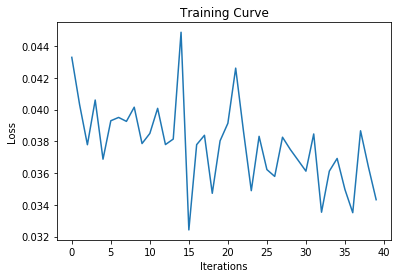

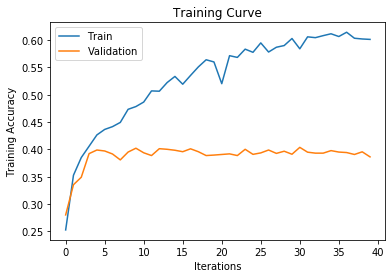

Final Training Accuracy: 0.6012147468569486
Final Validation Accuracy: 0.38634361233480174


In [13]:
model2 = AgeNet()
if use_cuda:
    model = model2.cuda()
train(model2, train_data, batch_size=32, lr=0.002, num_epochs=40)
torch.save(model2.state_dict(), 'models/model2.pth') # now I know that I should save it as a .pth file

training now...
Epoch 0 - Training Accuracy: 0.3624277947672443, Validation Accuracy: 0.38083700440528634
Epoch 1 - Training Accuracy: 0.3972562011552837, Validation Accuracy: 0.38502202643171807
Epoch 2 - Training Accuracy: 0.40039925246347263, Validation Accuracy: 0.37797356828193834
Epoch 3 - Training Accuracy: 0.41496772001359156, Validation Accuracy: 0.3975770925110132
Epoch 4 - Training Accuracy: 0.43284913353720694, Validation Accuracy: 0.41894273127753306
Epoch 5 - Training Accuracy: 0.4395174991505267, Validation Accuracy: 0.413215859030837
Epoch 6 - Training Accuracy: 0.4544257560312606, Validation Accuracy: 0.4182819383259912
Epoch 7 - Training Accuracy: 0.4585881753312946, Validation Accuracy: 0.4226872246696035
Epoch 8 - Training Accuracy: 0.4587580699966021, Validation Accuracy: 0.4193832599118943
Epoch 9 - Training Accuracy: 0.47532279986408427, Validation Accuracy: 0.42466960352422906
Epoch 10 - Training Accuracy: 0.4715426435609922, Validation Accuracy: 0.4281938325991

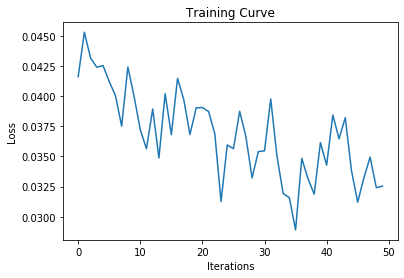

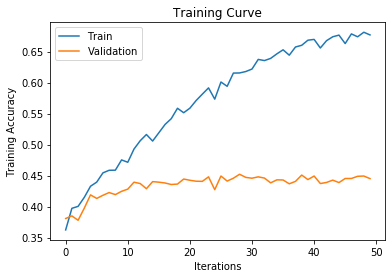

Final Training Accuracy: 0.6769028202514441
Final Validation Accuracy: 0.4451541850220264


In [14]:
# BEST SO FAR
model3 = AgeNet()
if use_cuda:
    model = model3.cuda()
train(model3, train_data, batch_size=32, lr=0.0005, num_epochs=50)
torch.save(model3.state_dict(), 'models/model3.pth')

training now...
Epoch 0 - Training Accuracy: 0.36234284743459055, Validation Accuracy: 0.3590308370044053
Epoch 1 - Training Accuracy: 0.38799694189602446, Validation Accuracy: 0.3841409691629956
Epoch 2 - Training Accuracy: 0.39967720013591573, Validation Accuracy: 0.38237885462555066
Epoch 3 - Training Accuracy: 0.40095141012572205, Validation Accuracy: 0.38722466960352425
Epoch 4 - Training Accuracy: 0.41462793068297654, Validation Accuracy: 0.39273127753303966
Epoch 5 - Training Accuracy: 0.4288990825688073, Validation Accuracy: 0.41035242290748897
Epoch 6 - Training Accuracy: 0.429366292898403, Validation Accuracy: 0.4182819383259912
Epoch 7 - Training Accuracy: 0.4278372409106354, Validation Accuracy: 0.39229074889867843
Epoch 8 - Training Accuracy: 0.4336136595310907, Validation Accuracy: 0.41519823788546256
Epoch 9 - Training Accuracy: 0.45378865103635746, Validation Accuracy: 0.41255506607929515
Epoch 10 - Training Accuracy: 0.4544257560312606, Validation Accuracy: 0.411453744

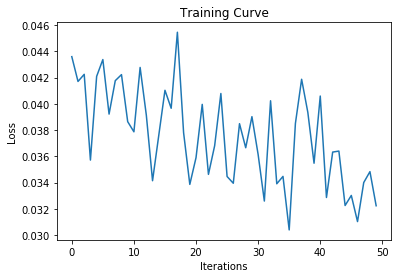

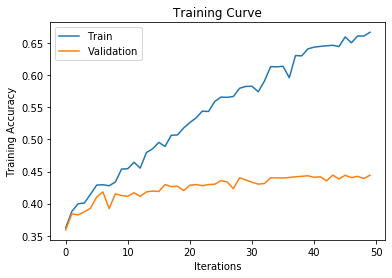

Final Training Accuracy: 0.6670064559972817
Final Validation Accuracy: 0.44427312775330396


In [15]:
model4 = AgeNet()
if use_cuda:
    model = model4.cuda()
train(model4, train_data, batch_size=32, lr=0.0002, num_epochs=50)
torch.save(model4.state_dict(), 'models/model4.pth')

training now...
Epoch 0 - Training Accuracy: 0.663098878695209, Validation Accuracy: 0.4359030837004405
Epoch 1 - Training Accuracy: 0.6753737682636766, Validation Accuracy: 0.4444933920704846
Epoch 2 - Training Accuracy: 0.6724855589534489, Validation Accuracy: 0.4403083700440529Epoch 3 - Training Accuracy: 0.6774125042473667, Validation Accuracy: 0.44493392070484583
Epoch 4 - Training Accuracy: 0.6802157662249405, Validation Accuracy: 0.4409691629955947
Epoch 5 - Training Accuracy: 0.6820846075433231, Validation Accuracy: 0.4403083700440529
Epoch 6 - Training Accuracy: 0.668960244648318, Validation Accuracy: 0.44273127753303965
Epoch 7 - Training Accuracy: 0.6798335032279986, Validation Accuracy: 0.4469162995594714
Epoch 8 - Training Accuracy: 0.6809378185524975, Validation Accuracy: 0.4488986784140969
Epoch 9 - Training Accuracy: 0.6893900781515461, Validation Accuracy: 0.4392070484581498
Epoch 10 - Training Accuracy: 0.6871389738362216, Validation Accuracy: 0.44052863436123346
Epoc

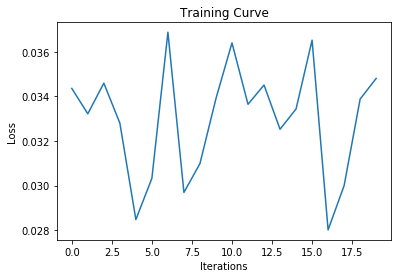

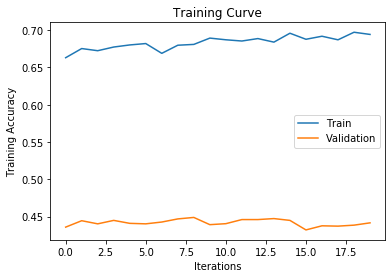

Final Training Accuracy: 0.6943170234454639
Final Validation Accuracy: 0.44162995594713655


In [16]:
# continue
train(model4, train_data, batch_size=32, lr=0.0002, num_epochs=20)
torch.save(model4.state_dict(), 'models/model4.pth')

#### Get validation accuracy for each age group

In [17]:
# function that calculates detailed accuracies in each category
def get_detailed_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    adult_correct, children_correct, senior_correct, youth_correct = 0, 0, 0, 0
    adult_total, children_total, senior_total, youth_total = 0, 0, 0, 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        pred = prob.max(1, keepdim=True)[1]
        for i in range(imgs.shape[0]):
            if labels[i] == 0:
                adult_correct += pred[i].eq(labels[i].view_as(pred[i])).item()
                adult_total += 1
            elif labels[i] == 1:
                children_correct += pred[i].eq(labels[i].view_as(pred[i])).item()
                children_total += 1
            elif labels[i] == 2:
                senior_correct += pred[i].eq(labels[i].view_as(pred[i])).item()
                senior_total += 1
            else:
                youth_correct += pred[i].eq(labels[i].view_as(pred[i])).item()
                youth_total += 1
    adult_acc = adult_correct/adult_total
    children_acc = children_correct/children_total
    senior_acc = senior_correct/senior_total
    youth_acc = youth_correct/youth_total
    return adult_acc, children_acc, senior_acc, youth_acc

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
get_detailed_accuracy(model, val_loader, batch_size)

(0.35905271199388844,
 0.4484339190221543,
 0.5141329258976318,
 0.31321619556913677)

## Use AlexNet

### Cannot make it overfit to small dataset :(

In [ ]:
batch_size = 32
num_workers = 0

# for alex
train_data = torchvision.datasets.DatasetFolder("alex/train", loader=torch.load, extensions=('.tensor'))
val_data = torchvision.datasets.DatasetFolder("alex/validation", loader=torch.load, extensions=('.tensor'))
test_data = torchvision.datasets.DatasetFolder("alex/test", loader=torch.load, extensions=('.tensor'))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# train size
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)
# validation size
val_dataiter = iter(val_loader)
val_features, val_labels = val_dataiter.next()
print("validation:", val_features.shape, val_labels.shape)
# test size
test_dataiter = iter(test_loader)
test_features, test_labels = test_dataiter.next()
print("test:", test_features.shape, test_labels.shape)

In [ ]:
# so the input size is now 256*3*3 only LMAO

In [ ]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = 'myAlexNet'
        # input layer is 256*3*3
        self.conv1 = nn.Conv2d(256, 256, 2, stride = 1, padding = 1) # output layer is 256*4*4
        self.fc1 = nn.Linear(256*4*4, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 256*4*4) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
overfit_model = AgeNet()
if use_cuda:
    overfit_model = overfit_model.cuda()
train(overfit_model, train_data, batch_size=32, lr=0.001, num_epochs=30, is_overfit=True)

In [ ]:
model = AgeNet()
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=30)